# Classification and Localization model

The objective is to build and train a classification and localization network. This exercise will showcase the flexibility of Deep Learning with several, heterogenous outputs (bounding boxes and classes)

We will build the model in three consecutive steps:
- **Extract label annotations** from a standard Object Detection dataset, namely **Pascal VOC 2007**;
- Use a pre-trained image classification model (namely ResNet18d) to **precompute convolutional representations** with shape `(512, 7, 7)` for all the images in the object detection training set;
- **Design and train a baseline object detection model with two heads** to predict: 
  - class labels (5 possible classes)
  - bounding box coordinates of a single detected object in the image

Note that the simple baseline model presented in this notebook will only detect a single occurence of a class per image. More work would be required to detect all possible object occurences in the images. See the lecture slides for refernces to state of the art object detection models such as Faster RCNN or RetinaNet.


## Loading images and annotations

We will be using Pascal VOC 2007, a dataset widely used in detection and segmentation http://host.robots.ox.ac.uk/pascal/VOC/ To lower memory footprint and training time, we'll only use 5 classes: "dog", "cat", "bus", "car", "aeroplane". Here are the first steps:
- Load the annotations file from pascalVOC and parse it (xml file)
- Keep only the annotations we're interested in, and containing a single object
- Pre-compute ResNet conv5c from the corresponding images


In [1]:
import torch


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
from urllib.request import urlretrieve
from pathlib import Path
import tarfile


PASCAL_VOC_ARCHIVE = Path("VOCtrainval_06-Nov-2007.tar")
PASCAL_VOC_FOLDER = Path("VOCdevkit")
PASCAL_VOC_URL = (
    "http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar"
)


if not PASCAL_VOC_FOLDER.exists():
    if not PASCAL_VOC_ARCHIVE.exists():
        print("Downloading PASCAL VOC dataset...")
        urlretrieve(PASCAL_VOC_URL, PASCAL_VOC_ARCHIVE)
    print("Extracting PASCAL VOC dataset...")
    with tarfile.open(PASCAL_VOC_ARCHIVE) as tar:
        tar.extractall()
    print("Done!")

In [3]:
ls VOCdevkit/VOC2007/

Annotations/  ImageSets/  JPEGImages/  SegmentationClass/  SegmentationObject/


In [4]:
IMAGE_FOLDER = PASCAL_VOC_FOLDER / "VOC2007/JPEGImages"

In [5]:
from __future__ import division
import numpy as np
import xml.etree.ElementTree as etree
import os
import os.path as op

# Parse the xml annotation file and retrieve the path to each image,
# its size and annotations
def extract_xml_annotation(filename):
    z = etree.parse(filename)
    objects = z.findall("./object")
    size = (int(z.find(".//width").text), int(z.find(".//height").text))
    fname = z.find("./filename").text
    dicts = [
        {
            obj.find("name").text:[
                int(obj.find("bndbox/xmin").text), 
                int(obj.find("bndbox/ymin").text), 
                int(obj.find("bndbox/xmax").text), 
                int(obj.find("bndbox/ymax").text),
            ]
        } 
        for obj in objects
    ]
    return {"size": size, "filename": fname, "objects": dicts}

In [6]:
# Filters annotations keeping only those we are interested in
# We only keep images in which there is a single item
annotations = []

filters = ["dog", "cat", "bus", "car", "aeroplane"]
idx2labels = {k: v for k, v in enumerate(filters)}
labels2idx = {v: k for k, v in idx2labels.items()}

annotation_folder = "VOCdevkit/VOC2007/Annotations/"
for filename in sorted(os.listdir(annotation_folder)):
    annotation = extract_xml_annotation(op.join(annotation_folder, filename))

    new_objects = []
    for obj in annotation["objects"]:
        # keep only labels we're interested in
        if list(obj.keys())[0] in filters:
            new_objects.append(obj)

    # Keep only if there's a single object in the image
    if len(new_objects) == 1:
        annotation["class"] = list(new_objects[0].keys())[0]
        annotation["bbox"] = list(new_objects[0].values())[0]
        annotation.pop("objects")
        annotations.append(annotation)

In [7]:
print("Number of images with a single annotation:", len(annotations))

Number of images with a single annotation: 1264


In [8]:
print("Contents of annotation[0]:\n", annotations[0])

Contents of annotation[0]:
 {'size': (500, 333), 'filename': '000007.jpg', 'class': 'car', 'bbox': [141, 50, 500, 330]}


In [9]:
print("Correspondence between indices and labels:\n", idx2labels)

Correspondence between indices and labels:
 {0: 'dog', 1: 'cat', 2: 'bus', 3: 'car', 4: 'aeroplane'}


## Pre-computing representations

Before designing the object detection model itself, we will pre-process all the dataset to project the images as spatial maps in a `(512, 7, 7)` dimensional space once and for all. The goal is to avoid repeateadly processing the data from the original images when training the top layers of the detection network.


### Exercise

- Load a pre-trained `ResNet18d` model from `timm` using the code below;
- Inspect the model with `torchinfo.summary` by specifying `input_size=(1, 3, 224, 224)`;
- Check that you can retrieve the list of all the layers in the model with: `list(resnet18d.children())`;
- Extract a sublist of layers excluding the last couple layers perform the 2D spatial pooling followed by the linear classification layer;
- Wrap the sublist of layers into a new model using  `conv_stem = torch.nn.Sequential(sublist_of_layers)`;
- Check that `conv_stem` output a tensor with the expected shape when feed with random test data generated with: `torch.randn(1, 3, 224, 224).to(device)`.

In [10]:
%pip install -q timm torchinfo

Note: you may need to restart the kernel to use updated packages.


In [11]:
import timm

resnet18d = timm.create_model("resnet18d", pretrained=True).to(device)

In [12]:
# TODO: write me


conv_stem = None  # TODO: update this line to store the result.

# Check the shape of the output of the stem model
# conv_stem(torch.randn(1, 3, 224, 224).to(device)).shape

### Solution

In [13]:
import timm
import torchinfo

resnet18d = timm.create_model("resnet18d", pretrained=True).to(device)
torchinfo.summary(resnet18d, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 32, 112, 112]         864
│    └─BatchNorm2d: 2-2                  [1, 32, 112, 112]         64
│    └─ReLU: 2-3                         [1, 32, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 32, 112, 112]         9,216
│    └─BatchNorm2d: 2-5                  [1, 32, 112, 112]         64
│    └─ReLU: 2-6                         [1, 32, 112, 112]         --
│    └─Conv2d: 2-7                       [1, 64, 112, 112]         18,432
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └

In [14]:
conv_stem = torch.nn.Sequential(*list(resnet18d.children())[:-2])
conv_stem(torch.randn(1, 3, 224, 224).to(device)).shape

torch.Size([1, 512, 7, 7])

### Extracting the convolutional features

The `predict_batch` function is defined as follows:
- open each image, and resize them to `img_size`
- stack them as a batch tensor of shape `(batch, 3, img_size_x, img_size_y)`
- preprocess the batch and make a forward pass with the model to extract the features

Let's first do it on a single image:

{'size': (500, 375), 'filename': '000099.jpg', 'class': 'cat', 'bbox': [4, 77, 320, 252]}


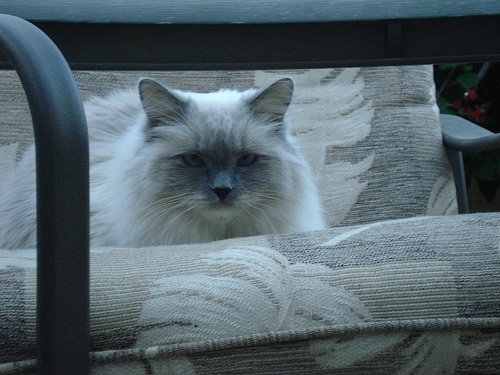

In [15]:
from IPython.display import Image

sample_idx = 12
print(annotations[sample_idx])
Image(IMAGE_FOLDER / annotations[sample_idx]['filename'], width=1000)

In [16]:
from timm.data.transforms_factory import create_transform

img_preprocessor = create_transform((1000, 224))  # intentional weird size!
img_preprocessor

Compose(
    ResizeKeepRatio(size=(1142, 256), interpolation=bilinear), longest=0.000)
    CenterCrop(size=(1000, 224))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [17]:
from PIL import Image

img_tensor = img_preprocessor(Image.open(IMAGE_FOLDER / annotations[0]['filename']))
print("output shape", conv_stem(img_tensor.to(device).unsqueeze(0)).shape)

output shape torch.Size([1, 512, 32, 7])


### Question

- Why do we get this output shape?


Let's extract the features for all the images with a single annotation. For the sake of simplicity we do that one image by one image. It might makes sense to use minibatches via the dataset classes of PyTorch or `timm` instead.

In [18]:
img_resize = 224
img_preprocessor = create_transform(img_resize)  # low resolution for this notebook

all_img_features = []
with torch.no_grad():  # important to avoid leaking GPU memory!
    for i, annotation in enumerate(annotations):
        img_pil = Image.open(IMAGE_FOLDER / annotation['filename'])
        img_tensor = img_preprocessor(img_pil).unsqueeze(0).to(device)
        all_img_features.append(conv_stem(img_tensor).cpu().squeeze())
        if i % 100 == 0:
            print(f"processed {i:04d} images")

all_img_features = torch.stack(all_img_features)
all_img_features.shape

processed 0000 images
processed 0100 images
processed 0200 images
processed 0300 images
processed 0400 images
processed 0500 images
processed 0600 images
processed 0700 images
processed 0800 images
processed 0900 images
processed 1000 images
processed 1100 images
processed 1200 images


torch.Size([1264, 512, 7, 7])

In [19]:
all_img_features.device

device(type='cpu')

### Question

How much memory is used in the GPU RAM by this `all_img_features` tensor? Use the following Python cell to do the computation. Recall that:

- 1 float32 number is represented by 32 bit;
- 1 Byte is 8 bits; 
- 1 MB is one million (1e6) Bytes, 1 GB is one billion Bytes (1e9)...

Do not confuse with MiB (1 MiB = 2^20 Bytes) and GiB which you can ignore and use powers of 10 which are easier to manipulate.

You can check that your computation is correct using numpy:

In [20]:
all_img_features.detach().cpu().numpy().nbytes / 1e6  # MB

126.844928

## Building ground truth from annotation

We cannot use directly the annotation dictionnary as ground truth in our model. 

We will build the `y_true` tensor that will be compared to the output of the model.

#### Boxes coordinates

- The image is resized to a fixed 224x224 to be fed to the usual ResNet18 input, the boxes coordinates of the annotations need to be resized accordingly.
- We have to convert the top-left and bottom-right coordinates `(x1, y1, x2, y2)` to center, height, width `(xc, yc, w, h)`

#### Classes labels

- The class labels are mapped to the corresponding integer indices

In [21]:
num_classes = len(labels2idx.keys())


def tensorize_ground_truth(annotations):
    all_boxes = []
    all_class_onehot = []
    all_class_indices = []
    for idx, annotation in enumerate(annotations):
        # Build a one-hot encoding of the class
        class_onehot = np.zeros(num_classes)
        class_idx = labels2idx[annotation["class"]]
        class_onehot[class_idx] = 1.0
        
        coords = annotation["bbox"]
        size = annotation["size"]
        # resize the image
        x1, y1, x2, y2 = (
            coords[0] * img_resize / size[0],
            coords[1] * img_resize / size[1], 
            coords[2] * img_resize / size[0],
            coords[3] * img_resize / size[1],
        )
        
        # compute center of the box and its height and width
        cx, cy = ((x2 + x1) / 2, (y2 + y1) / 2)
        w = x2 - x1
        h = y2 - y1
        boxes = np.array([cx, cy, w, h])
        all_boxes.append(boxes)
        all_class_onehot.append(class_onehot)
        all_class_indices.append(class_idx)

    # stack everything into two big np tensors
    return (
        np.vstack(all_class_onehot),
        np.asarray(all_class_indices),
        np.vstack(all_boxes),
    )

In [22]:
classes_onehot, classes_idx, boxes = tensorize_ground_truth(annotations)

In [23]:
print("Classes and boxes shapes:", classes_onehot.shape, classes_idx.shape, boxes.shape)

Classes and boxes shapes: (1264, 5) (1264,) (1264, 4)


In [24]:
print("First 2 classes labels:\n")
print(classes_onehot[0:2])

First 2 classes labels:

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


In [25]:
idx2labels

{0: 'dog', 1: 'cat', 2: 'bus', 3: 'car', 4: 'aeroplane'}

In [26]:
print("First 2 boxes coordinates:\n")
print(boxes[0:2])

First 2 boxes coordinates:

[[143.584      127.80780781 160.832      188.34834835]
 [113.568      123.43543544  87.36       116.37237237]]


### Interpreting output of model

Interpreting the output of the model is going from the output tensors to a set of classes (with confidence) and boxes coordinates. It corresponds to reverting the previous process.


In [27]:
def interpret_output(class_probability, boxes, img_size):
    class_idx = np.argmax(class_probability)
    confidence = class_probability[class_idx]
    classname = idx2labels[class_idx]
    cx, cy = boxes[0], boxes[1]
    w, h = boxes[2], boxes[3]
    
    small_box = [
        max(0, cx - w / 2),
        max(0, cy - h / 2), 
        min(img_resize, cx + w / 2),
        min(img_resize, cy + h / 2),
    ]
    fullsize_box = [
        int(small_box[0] * img_size[0] / img_resize), 
        int(small_box[1] * img_size[1] / img_resize),
        int(small_box[2] * img_size[0] / img_resize), 
        int(small_box[3] * img_size[1] / img_resize),
    ]
    output = {"class": classname, "confidence": confidence, "bbox": fullsize_box}
    return output

**Sanity check**: interpret the classes and boxes tensors of some known annotations:

In [28]:
img_idx = 1

print("Original annotation:\n")
print(annotations[img_idx])

Original annotation:

{'size': (500, 333), 'filename': '000012.jpg', 'class': 'car', 'bbox': [156, 97, 351, 270]}


In [29]:
interpreted_output = interpret_output(
    classes_onehot[img_idx],
    boxes[img_idx],
    img_size=annotations[img_idx]["size"],
)
print("Interpreted output:\n")
print(interpreted_output)

Interpreted output:

{'class': 'car', 'confidence': 1.0, 'bbox': [156, 97, 351, 270]}


### Intersection over Union

In order to assess the quality of our model, we will monitor the IoU between ground truth box and predicted box. 
The following function computes the IoU:

In [30]:
def iou(boxA, boxB):
    # find the intersecting box coordinates
    x0 = max(boxA[0], boxB[0])
    y0 = max(boxA[1], boxB[1])
    x1 = min(boxA[2], boxB[2])
    y1 = min(boxA[3], boxB[3])
    
    # compute the area of intersection rectangle
    inter_area = max(x1 - x0, 0) * max(y1 - y0, 0)

    # compute the area of each box
    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of areas - the interesection area
    return inter_area / float(boxA_area + boxB_area - inter_area)

In [31]:
iou([47, 35, 147, 101], [1, 124, 496, 235])

0.0

In [32]:
iou([47, 35, 147, 101], [47, 35, 147, 101])

1.0

In [33]:
iou([47, 35, 147, 101], [49, 36, 145, 100])

0.9309090909090909

#### Sanity check

The IoU of the bounding box of the original annotation with the bounding box of the interpretation of the resized version of the same annotation be close to 1.0:

In [34]:
for img_idx in range(10):
    original = annotations[img_idx]
    interpreted = interpret_output(
        classes_onehot[img_idx],
        boxes[img_idx],
        img_size=annotations[img_idx]["size"],
    )
    print(f'IoU: {iou(original["bbox"], interpreted["bbox"]):.3f}')

IoU: 1.000
IoU: 1.000
IoU: 0.997
IoU: 1.000
IoU: 0.996
IoU: 0.993
IoU: 0.991
IoU: 0.995
IoU: 0.994
IoU: 0.997


#### Visual sanity check

Matplotlib makes it possible to draw rectangles on a 2D plane as follows:

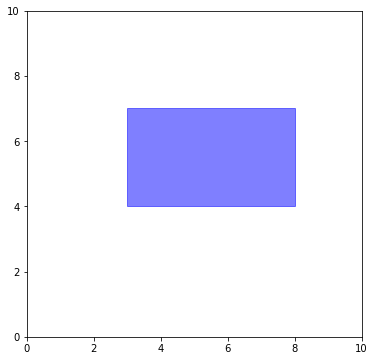

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_ylim(0, 10)
ax.set_xlim(0, 10)
ax.add_patch(plt.Rectangle((3, 4), 5, 3, color='blue', alpha=0.5));

### Exercise

Write a function that:

- takes 2 boxe tuples as arguments,
- plots the boxes as 2 rectangles in a (10 x 10) plane,
- and displays the value of IoU of the 2 boxes in the plt title.

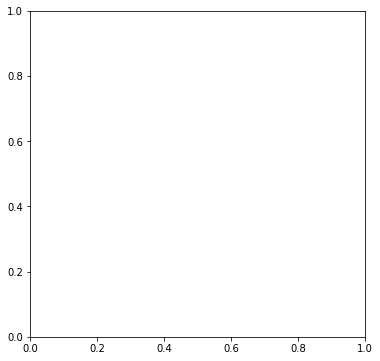

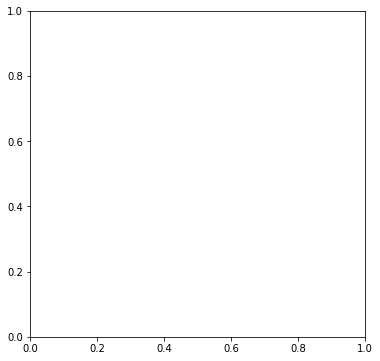

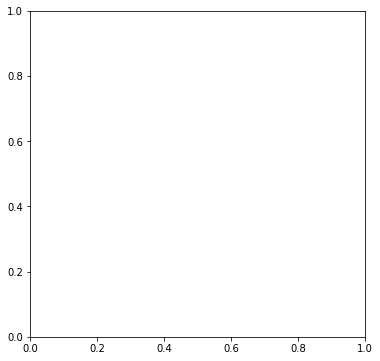

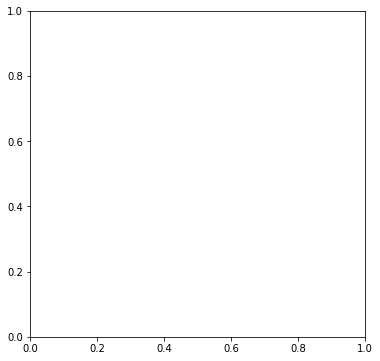

In [36]:
def plot_iou(boxA, boxB, img_size=(10, 10)):
    fig, ax = plt.subplots(figsize=(6, 6))
    # TODO: write me!
    
    # You can use the following code snippet to plot a rectangle at
    # position (x, y) with dimensions (w, h):
    # ax.add_patch(plt.Rectangle((x, y), w, h, color='blue', alpha=0.5))
    pass


plot_iou([2, 2, 8, 8], [3, 3, 7, 9])  # those are box corner coordinates!
plot_iou([2, 2, 8, 8], [2, 2, 8, 9])
plot_iou([2, 2, 8, 8], [0, 1, 1, 5])
plot_iou([2, 2, 8, 8], [1, 1, 10, 3])

### Solution

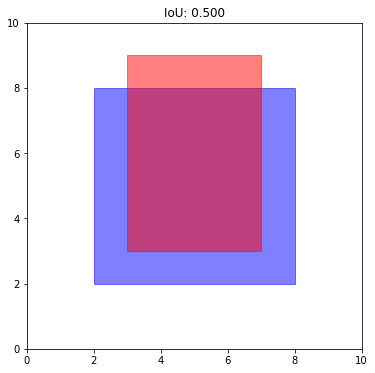

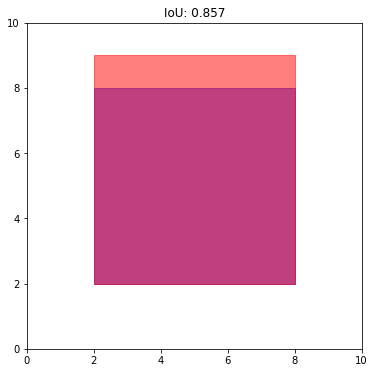

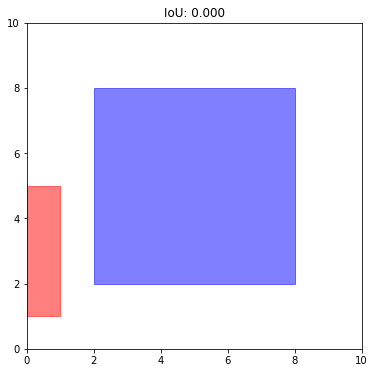

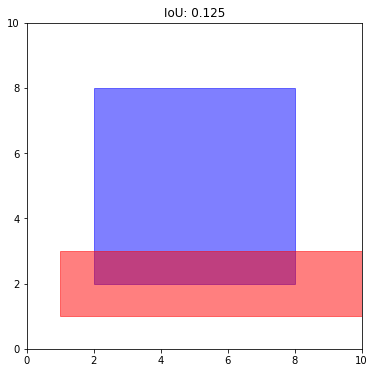

In [37]:
def plot_iou(boxA, boxB, img_size=(10, 10)):
    iou_value = iou(boxA, boxB)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title("IoU: {:0.3f}".format(iou_value))
    ax.set_ylim(0, 10)
    ax.set_xlim(0, 10)
    wA = boxA[2] - boxA[0]
    hA = boxA[3] - boxA[1]
    ax.add_patch(plt.Rectangle((boxA[0], boxA[1]), wA, hA,
                               color='blue', alpha=0.5))
    wB = boxB[2] - boxB[0]
    hB = boxB[3] - boxB[1]
    ax.add_patch(plt.Rectangle((boxB[0], boxB[1]), wB, hB,
                               color='red', alpha=0.5))


plot_iou([2, 2, 8, 8], [3, 3, 7, 9])
plot_iou([2, 2, 8, 8], [2, 2, 8, 9])
plot_iou([2, 2, 8, 8], [0, 1, 1, 5])
plot_iou([2, 2, 8, 8], [1, 1, 10, 3])

### Classification and Localization model

Let's start building a two headed model for single object classification and localization. We will naively stick two output heads on the spatially averaged convutional features:

In [38]:
class FlawedClassificationAndLocalization(torch.nn.Module):
    
    def __init__(self, num_classes, dropout_prob=0.1):
        super().__init__()
        self.pooling = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = torch.nn.Flatten()
        self.dropout = torch.nn.Dropout(dropout_prob)
        self.classifier_head = torch.nn.Linear(512, num_classes)
        self.localizer_head = torch.nn.Linear(512, 4)
        
    def forward(self, img_features):
        x = self.pooling(img_features)
        x = self.flatten(x)
        x = self.dropout(x)
        class_logits = self.classifier_head(x)
        bbox_coords = self.localizer_head(x)
        return class_logits, bbox_coords


flawed_model = FlawedClassificationAndLocalization(num_classes).to(device)

with torch.no_grad():
    flawed_model.eval()
    class_logits, bbox_coords = flawed_model(torch.randn(1, 512, 7, 7).to(device))

In [39]:
class_logits.shape

torch.Size([1, 5])

In [40]:
bbox_coords.shape

torch.Size([1, 4])

### Question

- How many trainable parameters in this model?

In [41]:
# %pip install -q torchinfo

In [42]:
# import torchinfo

# torchinfo.summary(flawed_model, (512, 7, 7))

Let's train our naive model.

Let's first do it on select only a few examples and test the model before training with random weights:

In [43]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader


(
    X_train, X_test,
    class_train, class_test,
    loc_train, loc_test,
    annotations_train, annotations_test,
) = train_test_split(
    all_img_features,
    torch.from_numpy(classes_idx),
    torch.from_numpy(boxes.astype(np.float32)),
    annotations,
    test_size=0.25,
    random_state=0,
)

In [44]:
X_train.shape, class_train.shape, loc_train.shape

(torch.Size([948, 512, 7, 7]), torch.Size([948]), torch.Size([948, 4]))

In [45]:
X_test.shape, class_test.shape, loc_test.shape

(torch.Size([316, 512, 7, 7]), torch.Size([316]), torch.Size([316, 4]))

### Displaying images and bounding box

Before training the model, let's evaluate the behavior and performance of our randomly initialized classification and localization heads:

In order to display our annotations, we build the function `plot_annotations` as follows:
- display the image
- display on top annotations and ground truth bounding boxes and classes

The `display` function:
- takes a single index and computes the result of the model
- interpret the output of the model as a bounding box
- calls the `plot_annotations` function

In [46]:
import matplotlib.pyplot as plt
import random
import PIL

rng = random.Random(42)


def patch(axis, bbox, display_txt, color):
    coords = (bbox[0], bbox[1]), bbox[2]-bbox[0]+1, bbox[3]-bbox[1]+1
    axis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    axis.text(bbox[0], bbox[1], display_txt, color='white',
              bbox={'facecolor': color, 'alpha': 0.7})


def plot_annotations(img_path, annotation=None, ground_truth=None, figsize=(10, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    img = np.asarray(PIL.Image.open(img_path))
    ax.imshow(img)
    if ground_truth:
        text = "gt " + ground_truth["class"]
        patch(ax, ground_truth["bbox"], text, "red")
    if annotation:
        conf = '{:0.2f} '.format(annotation['confidence'])
        text = conf + annotation["class"]
        patch(ax, annotation["bbox"], text, "blue")
    plt.axis('off')
    plt.show()


def display_prediction(model, annotations, features, ground_truth=True, sample_idx=None):
    if sample_idx is None:
        sample_idx = rng.choice(range(len(annotations)))
    with torch.no_grad():
        model.eval()
        class_pred, loc_pred = model(features[sample_idx].unsqueeze(0).to(device))
        class_pred = torch.nn.Softmax(dim=-1)(class_pred)
    output = interpret_output(
        class_pred.squeeze().cpu().numpy(),
        loc_pred.squeeze().cpu().numpy(),
        img_size=annotations[sample_idx]["size"],
    )
    plot_annotations("VOCdevkit/VOC2007/JPEGImages/" + annotations[sample_idx]["filename"], 
                     output, annotations[sample_idx] if ground_truth else None)

Let's display the predictions of the model and the ground truth annotation for a couple of images in our tiny debugging training set:

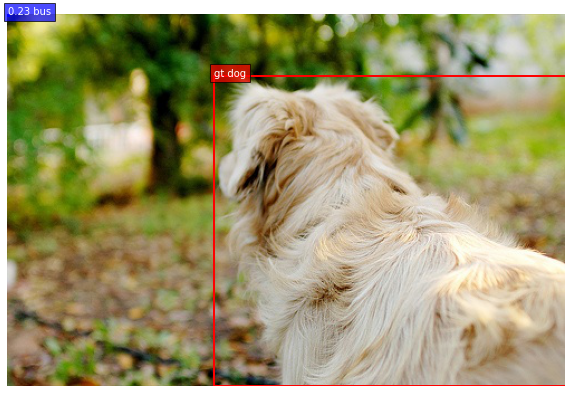

In [47]:
display_prediction(flawed_model, annotations_train, X_train)

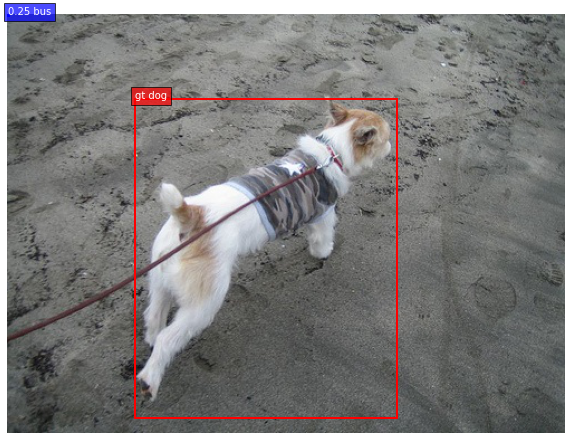

In [48]:
display_prediction(flawed_model, annotations_test, X_test)

The class should be right but the localization has little chance to be correct.

### Computing Accuracy

For each example `(class_true, bbox_true)`, we consider it positive if and only if:
- the argmax of `output_class` of the model is `class_true`
- the IoU between the `output_bbox` and the `bbox_true` is above a threshold (usually `0.5`)

The accuracy of a model is then number of positive / total_number

The following functions compute the class accuracy, iou average and global accuracy:

In [49]:
# Compute class accuracy, iou average and global accuracy
def accuracy_and_iou(preds, trues, threshold=0.5):
    sum_valid, sum_accurate, sum_iou = 0, 0, 0
    num = len(preds)
    for pred, true in zip(preds, trues):
        iou_value = iou(pred["bbox"], true["bbox"])
        if pred["class"] == true["class"] and iou_value > threshold:
            sum_valid = sum_valid + 1
        sum_iou = sum_iou + iou_value
        if pred["class"] == true["class"]:
            sum_accurate = sum_accurate + 1
    return sum_accurate / num, sum_iou / num, sum_valid / num

In [50]:
# Compute the previous function on the whole train / test set
def compute_acc(model, X, annotations, data_name="train"):
    model.eval()
    assert X.shape[0] == len(annotations)
    with torch.no_grad():
        class_pred, loc_pred = model(X.to(device))
    outputs = []
    for class_logits, box, annotation in zip(class_pred, loc_pred, annotations):
        output = interpret_output(
            class_logits.cpu().numpy(),
            box.cpu().numpy(),
            img_size=annotation["size"],
        )
        outputs.append(output)
    
    acc, iou, detect = accuracy_and_iou(outputs, annotations, threshold=0.5)
    
    print(
        f"[{data_name}] class accuracy: {acc:0.3f}, mean IoU: {iou:0.3f},"
        f" detector accuracy: {detect:0.3f}"
    )

In [51]:
compute_acc(flawed_model, X_train, annotations_train, "train")

[train] class accuracy: 0.176, mean IoU: 0.000, detector accuracy: 0.000


In [52]:
compute_acc(flawed_model, X_test, annotations_test, "test")

[test] class accuracy: 0.142, mean IoU: 0.000, detector accuracy: 0.000


So this is very bad, both on the training and test set, but this is expected, since the model is not trained.

In [53]:
def train_one_epoch(model, dataloader, class_loss_fn, loc_loss_fn, optimizer, loc_loss_scale=0.01):
    model.train()  # enable dropout layer(s)
    size = len(dataloader.dataset)
    class_loss_values = []
    class_correct = []
    loc_loss_values = []
    for batch, (X, y_class, y_loc) in enumerate(dataloader):
        class_pred, loc_pred = model(X)
        class_loss = class_loss_fn(class_pred, y_class)
        loc_loss = loc_loss_scale * loc_loss_fn(loc_pred, y_loc)

        class_loss_values.append(class_loss.item())
        loc_loss_values.append(loc_loss.item())
        
        optimizer.zero_grad()
        class_loss.backward(retain_graph=True)
        loc_loss.backward()
        optimizer.step()

    print(
        f"[train] class loss: {np.mean(class_loss_values):.4f}, "
        f"loc loss: {np.mean(loc_loss_values):.4f},"
    )

In [54]:
def train_model(model, X_train, annotations_train, X_test, annotations_test, num_epochs=200):
    train_dataset = TensorDataset(
        X_train.to(device), class_train.to(device), loc_train.to(device)
    )
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    classifier_loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.01)
    localizer_loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    for e in range(1, num_epochs + 1):
        train_one_epoch(
            model,
            train_dataloader,
            classifier_loss_fn,
            localizer_loss_fn,
            optimizer,
        )
        if e % 10 == 0:
            print(f"epoch {e:03d}:")
            model.eval()
            with torch.no_grad():
                compute_acc(model, X_train, annotations_train, "train")
                compute_acc(model, X_test, annotations_test, "test")


train_model(flawed_model, X_train, annotations_train, X_test, annotations_test)

[train] class loss: 1.5238, loc loss: 170.3221,
[train] class loss: 1.4544, loc loss: 156.9194,
[train] class loss: 1.4018, loc loss: 144.9837,
[train] class loss: 1.3503, loc loss: 133.7426,
[train] class loss: 1.3151, loc loss: 123.2767,
[train] class loss: 1.2740, loc loss: 113.9214,
[train] class loss: 1.2376, loc loss: 104.7854,
[train] class loss: 1.2079, loc loss: 96.3669,
[train] class loss: 1.1768, loc loss: 88.8569,
[train] class loss: 1.1415, loc loss: 81.8303,
epoch 010:
[train] class accuracy: 0.741, mean IoU: 0.034, detector accuracy: 0.000
[test] class accuracy: 0.696, mean IoU: 0.034, detector accuracy: 0.000
[train] class loss: 1.1237, loc loss: 75.8256,
[train] class loss: 1.0946, loc loss: 69.8604,
[train] class loss: 1.0692, loc loss: 64.6040,
[train] class loss: 1.0419, loc loss: 59.7815,
[train] class loss: 1.0211, loc loss: 55.6082,
[train] class loss: 1.0210, loc loss: 51.6483,
[train] class loss: 1.0002, loc loss: 48.2071,
[train] class loss: 0.9827, loc loss: 

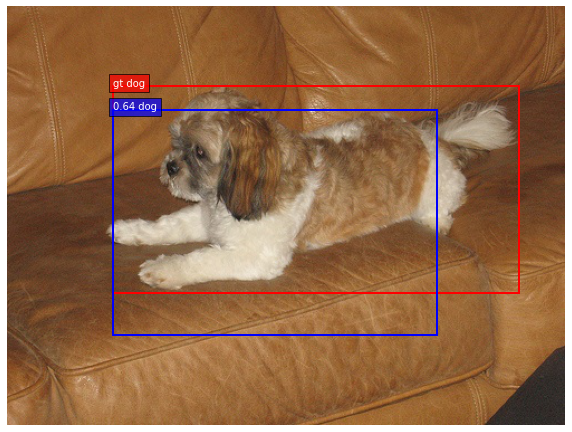

In [55]:
display_prediction(flawed_model, annotations_train, X_train)

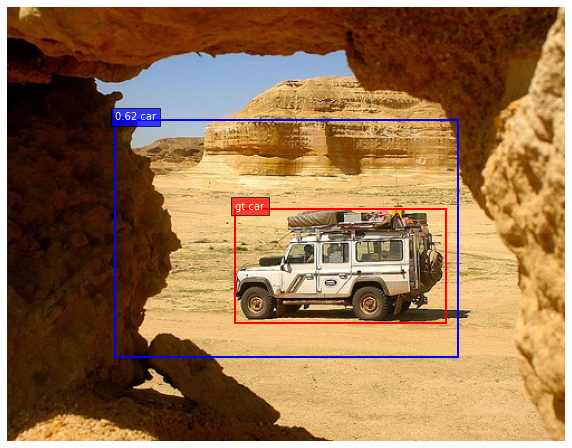

In [56]:
display_prediction(flawed_model, annotations_test, X_test)

The class accuracy is not too bad. The **localization quality measured by IoU** is **poor even when measured on the training set**.

### Question


- what can you say about the performance of the classification head of our model? is this part of the model overfitting / underfitting?
- what can you say about the performance of the localization head of our model? is this part of the model overfitting / underfitting?
- what in the architecture choices of our model can cause this problem with the localization head?

Note that this dataset is very small, so it should be quite easy to overfit if the model is well designed enough.

### Build a better model

**Exercise**

Use any tool at your disposal to build a better model:
- `Dropout`
- `Conv2d`, `Linear`, with non-linear activations functions
- `Flatten` and pooling layers

Notes:
- Be careful not to add too parametrized layers as you only have ~1200 training samples
- Feel free to modify hyperparameters: learning rate, optimizers, loss_weights

**Bonus**
- Try with a deeper resnet model;
- Add data augmentation (requires including the conv_stem as part of the model);
- flip images horizontally at random;
- approximately centered random crops before resizing.

Warning: using data-augmentation requires also adjusting the annotations accordingly: this is signifcantly more work!

In [57]:
class BetterClassificationAndLocalization(torch.nn.Module):
    
    def __init__(self, num_classes, dropout_prob=0.1):
        super().__init__()
        # TODO: implement me!
        
    def forward(self, img_features):
        x = self.dropout(img_features)

        # TODO: implement me!
        return class_logits, bbox_coords


better_model = BetterClassificationAndLocalization(num_classes).to(device)

# Uncomment the following code to check that your model works as expected:

# with torch.no_grad():
#     better_model.eval()
#     class_logits, bbox_coords = better_model(torch.randn(1, 512, 7, 7).to(device))
#
# class_logits.shape, bbox_coords.shape

In [58]:
# train_model(better_model, X_train, annotations_train, X_test, annotations_test, num_epochs=100)

## Solution

In [59]:
class BetterClassificationAndLocalization(torch.nn.Module):
    
    def __init__(self, num_classes, dropout_prob=0.1):
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout_prob)
        self.classifier_head = torch.nn.Sequential(
            torch.nn.AdaptiveAvgPool2d((1, 1)),
            torch.nn.Flatten(),
            torch.nn.Linear(512, num_classes),
        )
        self.localizer_head = torch.nn.Sequential(
            torch.nn.Conv2d(512, 16, kernel_size=3, padding="same"),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(16 * 7 * 7, 4),
        )
        
    def forward(self, img_features):
        x = self.dropout(img_features)
        class_logits = self.classifier_head(x)
        bbox_coords = self.localizer_head(x)
        return class_logits, bbox_coords


better_model = BetterClassificationAndLocalization(num_classes).to(device)


with torch.no_grad():
    better_model.eval()
    class_logits, bbox_coords = better_model(torch.randn(1, 512, 7, 7).to(device))

train_model(better_model, X_train, annotations_train, X_test, annotations_test, num_epochs=100)

[train] class loss: 1.5035, loc loss: 64.5057,
[train] class loss: 1.4382, loc loss: 23.7375,
[train] class loss: 1.3821, loc loss: 22.6403,
[train] class loss: 1.3299, loc loss: 22.3176,
[train] class loss: 1.2883, loc loss: 21.8546,
[train] class loss: 1.2482, loc loss: 21.3471,
[train] class loss: 1.2249, loc loss: 20.3379,
[train] class loss: 1.1759, loc loss: 19.7700,
[train] class loss: 1.1549, loc loss: 19.0952,
[train] class loss: 1.1246, loc loss: 18.0387,
epoch 010:
[train] class accuracy: 0.744, mean IoU: 0.434, detector accuracy: 0.364
[test] class accuracy: 0.696, mean IoU: 0.410, detector accuracy: 0.288
[train] class loss: 1.0916, loc loss: 17.0754,
[train] class loss: 1.0625, loc loss: 15.9299,
[train] class loss: 1.0386, loc loss: 14.8939,
[train] class loss: 1.0247, loc loss: 13.6767,
[train] class loss: 1.0012, loc loss: 12.5784,
[train] class loss: 0.9813, loc loss: 11.4297,
[train] class loss: 0.9609, loc loss: 10.2902,
[train] class loss: 0.9545, loc loss: 9.4561,

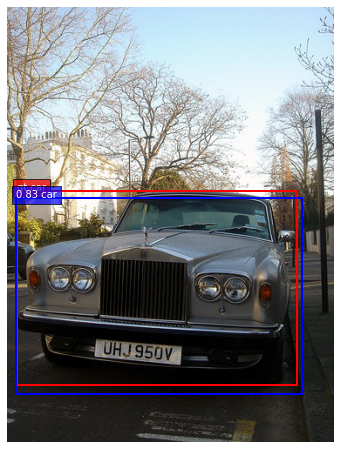

In [60]:
display_prediction(better_model, annotations_train, X_train)

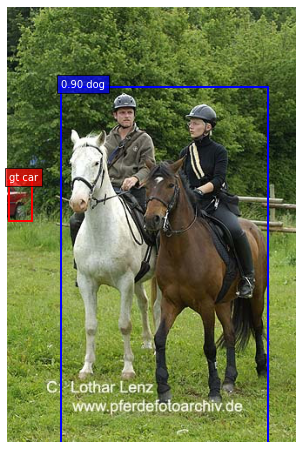

In [61]:
display_prediction(better_model, annotations_test, X_test)

So this model no longer underfits. However it overfits, both for classification and localization.

**Question**:

What would you suggest to fix the overfitting problem?